# Стартапы

### Описание

Исследование посвящено данными о стартапах, функционировавших в период с 1970 по 2018 годы. Необходимо предсказать, какие из них закроются.

В ходе работы необходимо выполнить следующее:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

### Импорт библиотек

In [80]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

### Загрузка данных

In [81]:
def primary_information(df):
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [82]:
startups_train = pd.read_csv('data/kaggle_startups_train_27042024.csv')
startups_test = pd.read_csv('data/kaggle_startups_test_27042024.csv')

In [87]:
primary_information(startups_train)
primary_information(startups_test)

Размерность: (52514, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), in

None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


Размерность: (13125, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


In [84]:
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [85]:
def cast_datetime(df):
    df['founded_at'] = pd.to_datetime(
        df['founded_at'], format="%Y-%m-%d"
    )
    df['first_funding_at'] = pd.to_datetime(
        df['first_funding_at'], format="%Y-%m-%d"
    )
    df['last_funding_at'] = pd.to_datetime(
        df['last_funding_at'], format="%Y-%m-%d"
    )

In [86]:
cast_datetime(startups_train)
cast_datetime(startups_test)

# Пропущенные значения в поле closed_at означают, что стартап не закрыт, поэтому заполним текущей датой
# для корректного расчета времени существования стартапа в днях
startups_train['closed_at'].fillna(datetime.date.today())
startups_train['closed_at'] = pd.to_datetime(
    startups_train['closed_at'], format="%Y-%m-%d"
)

In [88]:
def draw_boxplots(df, cols, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(cols[i])
        axs[i].set_ylabel('')
    fig.suptitle(title, fontsize=30);

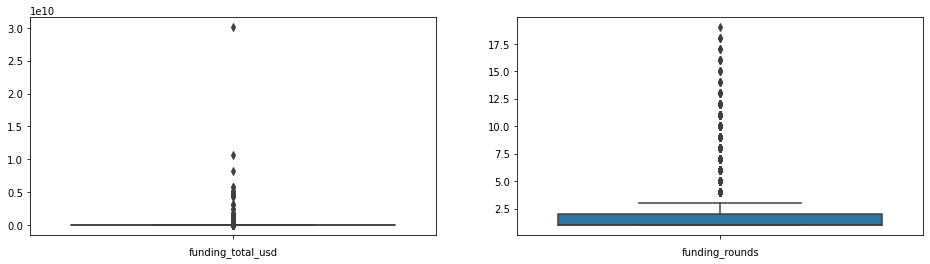

In [90]:
draw_boxplots(startups_train, ['funding_total_usd', 'funding_rounds'], '')

In [41]:
startups_train['category_list'].value_counts()[:60]

Software                            3207
Biotechnology                       2905
E-Commerce                          1063
Mobile                               920
Clean Technology                     892
Curated Web                          851
Health Care                          744
Hardware + Software                  733
Games                                681
Enterprise Software                  671
Health and Wellness                  613
Manufacturing                        604
Advertising                          554
Education                            422
Semiconductors                       400
Real Estate                          338
Finance                              338
Consulting                           330
Social Media                         326
Security                             317
Hospitality                          278
Web Hosting                          277
Analytics                            261
Fashion                              254
Technology      

In [33]:
startups_train['category_list'].str.contains('Software', na=False).sum()

10253

In [42]:
startups_train[startups_train['category_list'].str.contains('Software', na=False)]['category_list']

6        Analytics|Business Analytics|Social CRM|Social...
7                                                 Software
10                                                Software
13                                                Software
17       Analytics|Cloud Data Services|Computers|Networ...
                               ...                        
52484                                  Hardware + Software
52486               Information Services|Services|Software
52494                                  Hardware + Software
52499                                             Software
52511                Email|Messaging|Productivity Software
Name: category_list, Length: 10253, dtype: object

0     2024-06-07
1     2024-06-07
2     2024-06-07
3     2024-06-07
4     2024-06-07
5     2024-06-07
6     2024-06-07
7     2024-06-07
8     2024-06-07
9     2024-06-07
10    2024-06-07
11    2024-06-07
12    2015-07-25
13    2024-06-07
14    2024-06-07
15    2024-06-07
16    2014-11-02
17    2024-06-07
18    2024-06-07
19    2024-06-07
Name: closed_at, dtype: object